This is the starting point for the whole challenge. In order to experiment and to take confidence with the environment, we tried to adapt the simplest CNN we have seen during the exercise sessions. 

In [ ]:
#!unzip dataset.zip

In [ ]:
#!pip install split-folders

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


NameError: name 'dataset_dir' is not defined

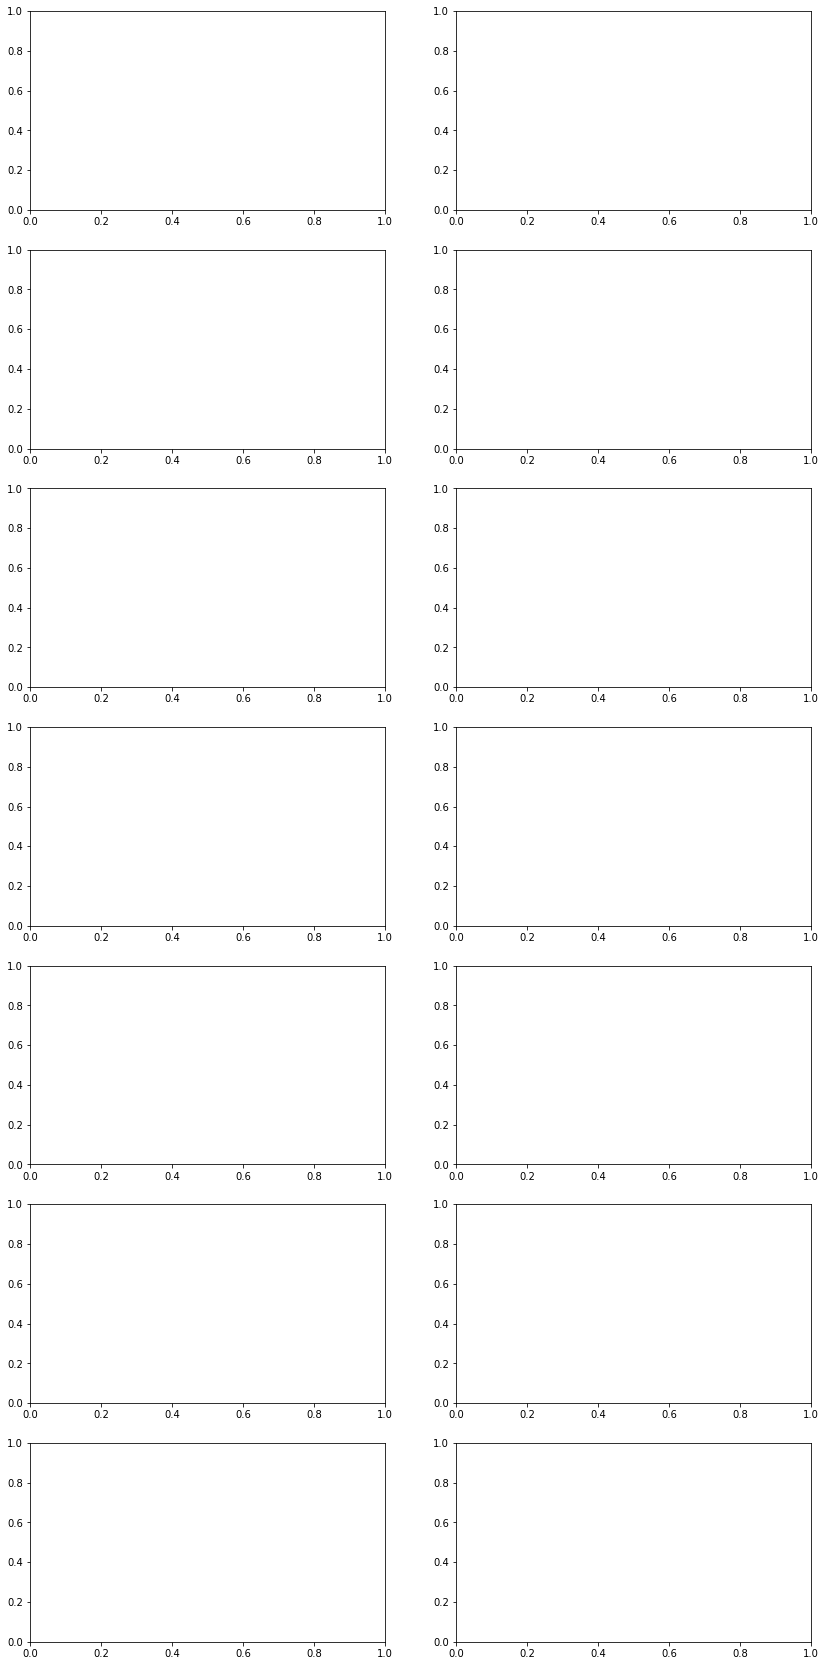

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Set Seed

In [ ]:
# Random seed for reproducibility

n_classes = 14
seed = 22 #Gonzales o Chiesa

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

dataset_dir = 'training\\'

In [ ]:
#splitfolders.ratio(dataset_dir, output="Split", seed=seed, ratio=(.7, 0.15,0.15)) 

#Data Loader

In [ ]:
train_dir = '..\\Split\\train\\'
val_dir = '..\\Split\\val\\'
test_dir = '..\\Split\\test\\'

# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rescale=1/255.)
val_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=train_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
val_gen = val_data_gen.flow_from_directory(directory=val_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)


Found 12403 images belonging to 14 classes.
Found 2652 images belonging to 14 classes.
Found 2673 images belonging to 14 classes.


In [ ]:
#TODO
#Data augmentation, come portare tutte le classi allo stesso numero di elementi
#capire forma del submit

#Data Loader with augmentation

Data augmentation has been implemented only on the training set. We could train the network two times: one with data augmentation and another one without, then submit both the networks in order to show an improvement on the leaderboard (or, at least, I hope so)

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
# TODO: we have to reason on the right values for the parameters of the
# generator.

aug_train_data_gen = ImageDataGenerator(rotation_range=45,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=train_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

Found 12403 images belonging to 14 classes.


# Model definition

Here we have defined the model for this first implementation. It is a CNN with the following structure: (Conv + ReLU + MaxPool) x 5 + FC x 2

This is the model of the CNN that was used as an example during the exercise session.

#### Model metadata


In [ ]:
input_shape = (256, 256, 3)
epochs = 200
exps_dir = os.path.join('..\\data_augmentation_experiments\\')
!dir ..\\data_augmentation_experiments\\

 Il volume nell'unit… G Š Google Drive
 Numero di serie del volume: 1983-1116

 Directory di G:\Il mio Drive\[ANNDL] GengisGAN\CH1\data_augmentation_experiments

16/11/2021  23:44    <DIR>          .
14/11/2021  12:32    <DIR>          ..
15/11/2021  16:48    <DIR>          CNN_NoAug_Nov15_15-48-30
15/11/2021  17:14    <DIR>          CNN_Aug_Nov15_16-14-28
15/11/2021  17:19    <DIR>          CNN_Aug_Nov15_16-19-24
15/11/2021  17:56    <DIR>          CNN_NoAug_Base
15/11/2021  22:18    <DIR>          CNN_Aug_Base
16/11/2021  15:55    <DIR>          Xception_Aug_Nov16_14-55-38
16/11/2021  15:57    <DIR>          Xception_Aug_Nov16_14-57-14
16/11/2021  15:57    <DIR>          Xception_Aug_Nov16_14-57-53
16/11/2021  15:59    <DIR>          Xception_Aug_Nov16_14-59-04
16/11/2021  23:31    <DIR>          CNN_NoAug_Nov16_23-31-26
16/11/2021  23:34    <DIR>          CNN_NoAug_Nov16_23-34-50
16/11/2021  23:44    <DIR>          CNN_NoAug_Nov16_23-44-13
               0 File              0 byte
 

#### CNN definition

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=n_classes, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('..\\data_augmentation_experiments\\')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0     

In [ ]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200


In [ ]:
model.save("data_augmentation_experiments/CNN_NoAug_Base")

In [ ]:
model_no_aug = tfk.models.load_model("data_augmentation_experiments/CNN_NoAug_Base")
model_no_aug_test_metrics = model_no_aug.evaluate(test_gen, return_dict=True)

In [ ]:
model_no_aug_test_metrics